# Automobiles and Customer Satisfaction

**Goal: Identify autombile customer satisfaction using association rules, K-Means clustering, and K-Nearest neighbors classification.**  

Datasets:  
    [car data](https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset.csv)  
    [binary car data](https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset_logical.csv)

I will begin the data exploration phase by limiting number of threads used and importing essential libraries for exploration.

In [1]:
# setting number of threads to six
import os
os.environ["OMP_NUM_THREADS"] = "6"

# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config Completer.use_jedi = False

In [2]:
# reading in car dataset from github repository
url = "https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset.csv"
car_data = pd.read_csv(url)

In [3]:
# shuffling dataset
car_data = car_data.iloc[:, 1:].sample(frac=1).reset_index(drop=True)

In [4]:
# first five rows
car_data.head()

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,Rating
0,med,med,5more,2,med,med,unacc
1,vhigh,low,4,2,big,med,unacc
2,low,med,3,4,small,high,good
3,high,high,4,4,big,high,acc
4,high,low,2,2,small,med,unacc


In [5]:
# general variable info
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Purchase Price     1728 non-null   object
 1   Maintenance Costs  1728 non-null   object
 2   Doors              1728 non-null   object
 3   Persons            1728 non-null   object
 4   Luggae Boot        1728 non-null   object
 5   Safety             1728 non-null   object
 6   Rating             1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


There are no null values present in the dataset. Also, all of the columns are object types. Let's count the values using barplots to make sure they were imported as the correct data type. It will also give us a chance to look at the distribution among columns.

In [6]:
# retrieving general statistics for numerical variables
car_data.describe()

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,Rating
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,low,low,2,2,big,low,unacc
freq,432,432,432,576,576,576,1210


All of the columns have 3-4 unique values. Most of them seem to be ordinal variables. Let's make sure that's the case.

In [7]:
# storing column names
col_names = car_data.columns

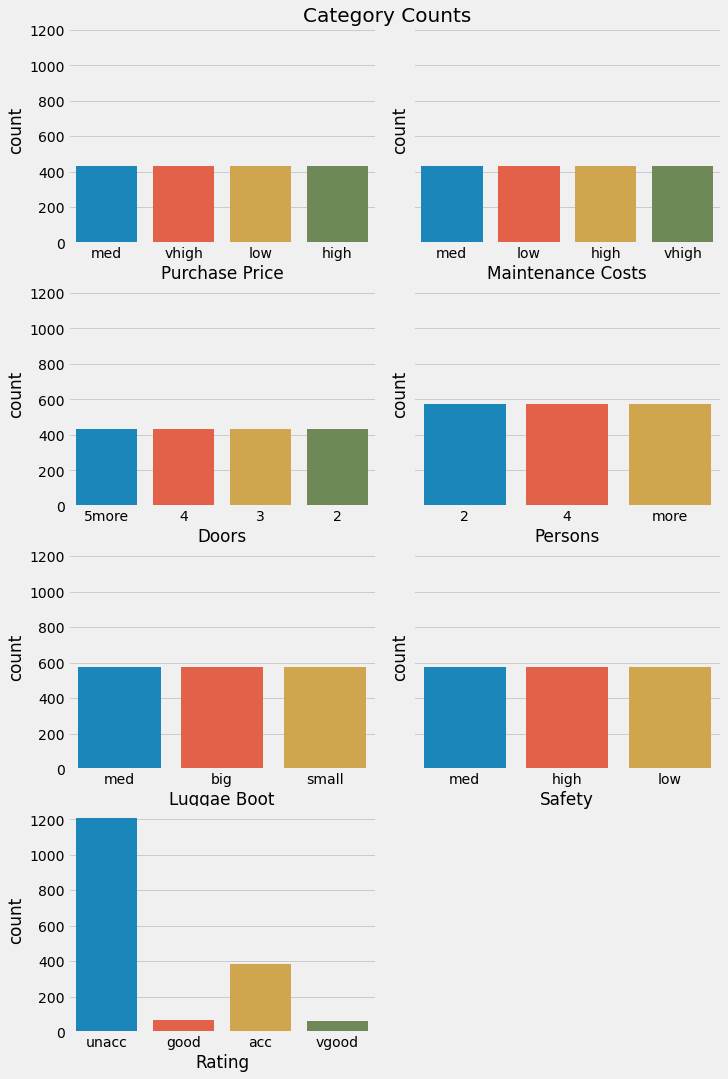

In [8]:
# counting variables using barplots
plt.style.use("fivethirtyeight")
fig, axes = plt.subplots(4, 2, figsize=(10, 15), sharey=True) # creates figure and axes
fig.tight_layout() # removes extra whitespaces
fig.subplots_adjust(top=0.97)
fig.suptitle("Category Counts", fontsize=20); # spacing out title

# adding plots to subplots
sns.countplot(ax=axes[0, 0], data=car_data, x=col_names[0]);
sns.countplot(ax=axes[0, 1], data=car_data, x=col_names[1]);
sns.countplot(ax=axes[1, 0], data=car_data, x=col_names[2]);
sns.countplot(ax=axes[1, 1], data=car_data, x=col_names[3]);
sns.countplot(ax=axes[2, 0], data=car_data, x=col_names[4]);
sns.countplot(ax=axes[2, 1], data=car_data, x=col_names[5]);
sns.countplot(ax=axes[3, 0], data=car_data, x=col_names[6]);
axes[-1, -1].axis("off");

Yes, they all seem to be ordinal variables. I am not sure how this will affect the K-Means and K-Nearest Neighbors classificaiton algorithms. It might be hard to visualize clusters using K-Means. All of the columns have a fixed number of unique values. A K-Nearest Neighbors classifier might overfit the data due to possibly having seen most of the holdout data during training.

### Association Rules

In this section, I will use association rules on a binary format version of the car dataset. The first goal is to determine three rules with two items with the strongest support. The second goal is similar to the first one, but instead of finding three rules with two items, I will find three rules with three items.

In [9]:
# reading in binary car dataset from github repository
url = "https://raw.githubusercontent.com/crosstrack10/data-science-projects/main/datasets/car_evaluation_dataset_logical.csv"
binary_car_data=pd.read_csv(url).sample(frac=1).reset_index(drop=True)

In [10]:
# retrieving general statistics for numerical variables
binary_car_data.describe()

,2door,2person,3door,4door,4person,5moredoor,acc,bigluggage,good,highmaint,...,medluggage,medmaint,medpurchase,medsafety,moreperson,smallluggage,unacc,vgood,vhighmaint,vhighpurchase
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,0.250000,0.333333,0.250000,0.250000,0.333333,0.250000,0.222222,0.333333,0.039931,0.250000,...,0.333333,0.250000,0.250000,0.333333,0.333333,0.333333,0.700231,0.037616,0.250000,0.250000
std,0.433138,0.471541,0.433138,0.433138,0.471541,0.433138,0.415860,0.471541,0.195853,0.433138,...,0.471541,0.433138,0.433138,0.471541,0.471541,0.471541,0.458289,0.190320,0.433138,0.433138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.250000,1.000000,0.250000,0.250000,1.000000,0.250000,0.000000,1.000000,0.000000,0.250000,...,1.000000,0.250000,0.250000,1.000000,1.000000,1.000000,1.000000,0.000000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
# importing apriori model and association rules
from mlxtend.frequent_patterns import apriori, association_rules

# builiding the model
freq_items = apriori(binary_car_data, min_support=0.05, use_colnames=True)

# collecting rules in a dataframe
rules = association_rules(freq_items, metric="lift", min_threshold=0.05)
rules = rules.sort_values(["support", "confidence"], ascending=[False, False])

In [12]:
# top 3 single item frequent item sets
rules.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
66,(2person),(unacc),0.333333,0.700231,0.333333,1.000000,1.428099,0.099923,inf
368,(lowsafety),(unacc),0.333333,0.700231,0.333333,1.000000,1.428099,0.099923,inf
67,(unacc),(2person),0.700231,0.333333,0.333333,0.476033,1.428099,0.099923,1.272345


The top three rules with the strongest support with two items reveal some interesting findings. All three rules have the support of about 0.33. A two person vehicle antecedent and a consequent unacceptable rating have the confidence of 1.00. The same can be said for a low safety vehicle and a consequent unacceptable rating. An antecedent unacceptable rating and a consequent two person vehicle have the confidence of about 0.48. From a business perspective, these findings may indicate unacceptable car ratings are usually associated with two person and low safety vehicles. These rules might make a business purchase fewer two person and low safety vehicles. 

In [13]:
# top 3 double item frequent item sets
rules.loc[rules["antecedents"].astype(str).str.count(",") == 1].head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
518,"(2person, bigluggage)",(unacc),0.111111,0.700231,0.111111,1.0,1.428099,0.033308,inf
536,"(2person, highsafety)",(unacc),0.111111,0.700231,0.111111,1.0,1.428099,0.033308,inf
554,"(lowsafety, 2person)",(unacc),0.111111,0.700231,0.111111,1.0,1.428099,0.033308,inf


These three rules with three items reveal two person vehicles are still associated with unacceptable ratings. The confidence level for each rules is 1.0. The biggest issue with two person vehicles is room capacity and safety to a degree.

### K-Means Clustering

This section will include a K-Means clustering classification algorithm. The goal is to find patterns around unacceptable ratings and non-unacceptable ratings.

In [14]:
# converting categorical variable to numerical
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
X = pd.DataFrame() 

for i in car_data.columns :
  X[i] = label.fit_transform(car_data[i])

y = X.Rating
X = X.iloc[:, :-1]

In [15]:
# first five rows
X.head()

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety
0,2,2,3,0,1,2
1,3,1,2,0,0,2
2,1,2,1,1,2,0
3,0,0,2,1,0,0
4,0,1,0,0,2,2


I decided to only include a number of clusters range from 1-7 to minimize overfitting the data. It will also help from a computational performance aspect.

In [16]:
# importing GridSearchCv for parameter tuning
from sklearn.model_selection import GridSearchCV

# instance of knn classifier
from sklearn.cluster import KMeans
kmeans = KMeans()

# grid parameter values
params = {
    "n_clusters": np.arange(1, 7)
}

# testing all values in the model
grid = GridSearchCV(kmeans, params, cv=5)

# fitting model to data
grid.fit(X)

GridSearchCV(cv=5, estimator=KMeans(),
             param_grid={'n_clusters': array([1, 2, 3, 4, 5, 6])})

In [17]:
# displaying grid search results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score").reset_index(drop=True)
results[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.055674,0.002307,0.001706,0.000469,6,{'n_clusters': 6},-1122.097332,-1136.284854,-1114.665102,-1099.988617,-1101.791812,-1114.965543,13.441140,1
1,0.047983,0.002582,0.002027,0.000202,5,{'n_clusters': 5},-1217.699868,-1226.145908,-1215.918366,-1186.600210,-1202.157749,-1209.704420,13.882504,2
2,0.040978,0.002351,0.001928,0.000288,4,{'n_clusters': 4},-1311.301580,-1339.487532,-1298.912529,-1275.053935,-1299.605813,-1304.872278,20.937715,3
3,0.035499,0.003421,0.001845,0.000234,3,{'n_clusters': 3},-1473.601998,-1497.618048,-1452.393666,-1429.990831,-1479.854102,-1466.691729,23.361625,4
4,0.026808,0.000251,0.002013,0.000293,2,{'n_clusters': 2},-1677.255946,-1693.697673,-1655.086391,-1596.787411,-1678.369930,-1660.239470,34.030702,5


Six clusters returns the highest mean distance test score **(-1117.90)**. I use this model to predict target values.

In [18]:
# predicting target values
pred_target = grid.predict(X)
pd.Series(pred_target).value_counts(normalize = True).sort_index()

0    0.203125
1    0.140625
2    0.203125
3    0.156250
4    0.156250
5    0.140625
dtype: float64

The clusters have similar relative frequencies.

It will be difficult to visualize clusters due to the high number of categorical features. Even using methods like PCA might not be beneficial. A possible solution is to use stripplots with the rating as a hue. Reducing the number of unique values in the rating column to "unacceptable" and "acceptable" will make it easier to find meaningful insights.

In [19]:
# creating new dataframe with features and predicted targets
df_results = X.copy()
df_results['New Rating'] = car_data['Rating'].apply(lambda x: "unacc" if x == "unacc" else 'acc')
df_results["Cluster"] = pred_target
df_results[:10]

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,New Rating,Cluster
0,2,2,3,0,1,2,unacc,0
1,3,1,2,0,0,2,unacc,0
2,1,2,1,1,2,0,acc,1
3,0,0,2,1,0,0,acc,3
4,0,1,0,0,2,2,unacc,1
5,2,3,3,0,0,1,unacc,4
6,2,2,2,2,0,0,acc,0
7,3,0,1,1,2,0,unacc,2
8,2,1,0,0,1,2,unacc,2
9,3,1,3,1,2,0,acc,0


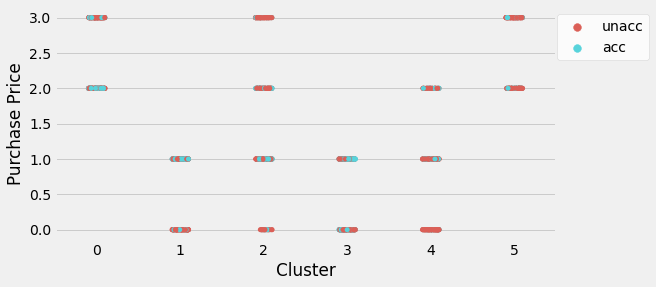

In [20]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Purchase Price", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

Clusters 1-3 have more acceptable car ratings in low-medium price range. Clusters 0 and 4-5 have more acceptable car ratings in the medium-high range.

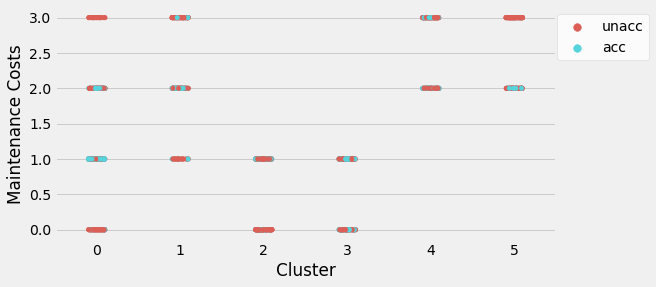

In [21]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Maintenance Costs", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

Clusters 0 and 3 have more acceptable car ratings due to low-high maintenance costs. Clusters 1 and 4 have fewer acceptable car ratings because most vehicles have high-very high maintenance costs. 

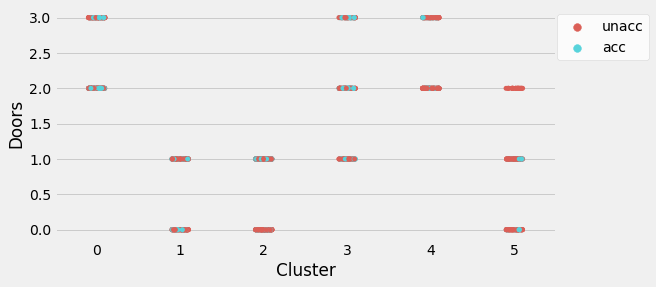

In [22]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Doors", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

The doors clusters do not indicate any useful insights. The acceptable ratings are all over the place.

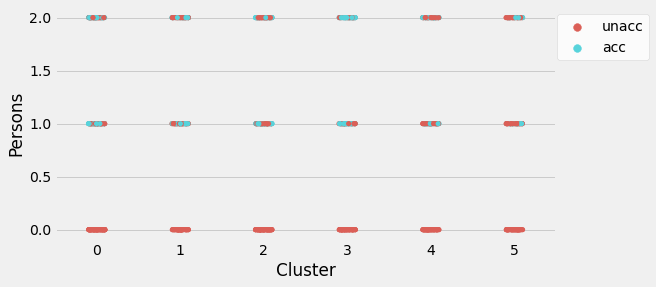

In [23]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Persons", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

All clusters have a high number of unacceptable car ratings for two person vehicles. On the contrast, all of them have a good amount of vehicles with acceptable car ratings for four person or more than four person vehicles.

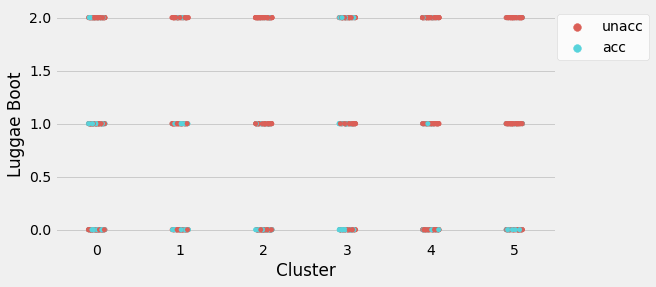

In [24]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Luggae Boot", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

The first two cluster have more acceptable car ratings for low-medium luggage vehicles.

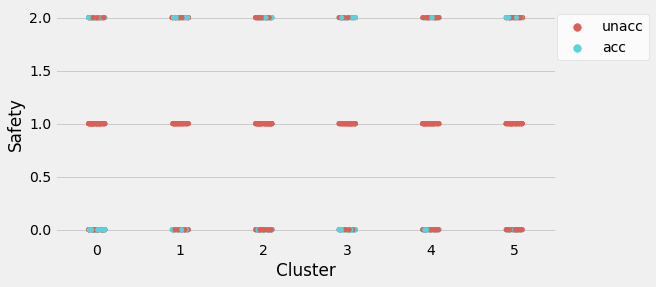

In [25]:
# using swarm plots to visualize clusters
plt.figure(figsize=(8,4))
sns.stripplot(x="Cluster", y="Safety", hue="New Rating", palette="hls", jitter=True, data=df_results);
plt.legend(facecolor="white", bbox_to_anchor=(1.2, 1))
plt.show()

Cluster 1, 3, and 5 have a lot of acceptable car ratings for high safety vehicles. However, there are many acceptable car ratings for low safe vehicles across all cluster. I wonder if their associated with another feature we have seen?

Two features that might be interesting from a business perspective are purchase price and maintenance costs. The purchase price variable has an even number of clusters with a high amount of acceptable car ratings in different price ranges. Clusters 1-3 have many acceptable car ratings from low-mid purchase prices, while clusters 0, 4, and 5 have many from high-very high purchase prices. For maintenance costs, clusters with low-medium costs have more acceptable car ratings. These feature patterns are easy to identify separately using stripplots.

### K-Nearest Neighbors Classification

The objective with a K-Nearest Neighbor classifier is to determine accuracy, precision, recall, and f1 scores for the target **"ratings"**.

In [26]:
# importing scikit-learn packages for KNeighbors classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [27]:
# features
X = car_data.iloc[:, :-1]
print(X.shape)

# target
y = car_data.Rating
print(y.shape)

(1728, 6)
(1728,)


Splitting the data into traning and testing for a final holdout validation set.
20% will be used for the testing set.

In [28]:
# splitting the data using K-Folds Cross Validation
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
print("X_train:", len(X_train), "X_test:", len(X_test),
      "y_train:", len(X_train), "y_test:", len(X_test))

X_train: 1382 X_test: 346 y_train: 1382 y_test: 346


In [29]:
# creating Simple Imputer, OneHot Encoder, and Standard Scaler objects
constant_imp = SimpleImputer(strategy="most_frequent")
ohe = OneHotEncoder(handle_unknown="ignore")

In [30]:
# creating pipeline for categorical variable transformations
imp_ohe = make_pipeline(constant_imp, ohe)

In [31]:
# transforming variables using a column transformer
ct_imputer = make_column_transformer(
    (imp_ohe, X.columns)
)

In [32]:
# creating an instance of knn classifier
knn = KNeighborsClassifier(n_neighbors=3)

In [33]:
# creating a pipeline
pipe = make_pipeline(ct_imputer, knn)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Purchase Price', 'Maintenance Costs', 'Doors', 'Persons',
       'Luggae Boot', 'Safety'],
      dtype='object'))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [34]:
# using cross val score function to test model accuracy
from sklearn.model_selection import cross_val_score
round(cross_val_score(pipe, X, y, cv=5, scoring="f1_macro").mean(), 3)

0.609

In [35]:
# retrieving named steps in the pipeline
pipe.named_steps.keys()

dict_keys(['columntransformer', 'kneighborsclassifier'])

Two important parameters than can use tuning are:
- number of neighbors
- weights  

The max number of neighbors will be 25. Weights can only uniform or distance measurements.

In [36]:
# grid parameter values
params = {
    "kneighborsclassifier__n_neighbors": np.arange(1, 25),
    "kneighborsclassifier__weights": ["uniform", "distance"]
}

In [37]:
# creating grid search CV instance
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(pipe, params, cv=5, scoring="f1_macro")
grid.fit(X, y);

In [38]:
# displaying grid search results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score").reset_index(drop=True)[:10]
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,param_kneighborsclassifier__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.022055,0.011896,0.037149,0.014201,11,distance,"{'kneighborsclassifier__n_neighbors': 11, 'kne...",0.719055,0.822225,0.779434,0.838576,0.719297,0.775718,0.050044,1
1,0.010879,0.000660,0.020863,0.000807,9,distance,"{'kneighborsclassifier__n_neighbors': 9, 'knei...",0.710017,0.818615,0.739502,0.819285,0.742144,0.765913,0.044750,2
2,0.010714,0.000665,0.028080,0.003077,9,uniform,"{'kneighborsclassifier__n_neighbors': 9, 'knei...",0.710017,0.818615,0.739502,0.819285,0.742144,0.765913,0.044750,2
3,0.011429,0.000597,0.028469,0.001667,11,uniform,"{'kneighborsclassifier__n_neighbors': 11, 'kne...",0.719055,0.809079,0.779434,0.819311,0.693526,0.764081,0.049631,4
4,0.010429,0.001195,0.020428,0.002376,12,distance,"{'kneighborsclassifier__n_neighbors': 12, 'kne...",0.707205,0.834049,0.784011,0.742362,0.718969,0.757319,0.046488,5
5,0.016091,0.002098,0.031180,0.005553,10,distance,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.689499,0.819699,0.764017,0.800045,0.709179,0.756488,0.050349,6
6,0.011199,0.000563,0.028504,0.017575,13,distance,"{'kneighborsclassifier__n_neighbors': 13, 'kne...",0.708510,0.848175,0.787258,0.767578,0.669058,0.756116,0.062324,7
7,0.010843,0.000739,0.029120,0.002320,10,uniform,"{'kneighborsclassifier__n_neighbors': 10, 'kne...",0.689499,0.819699,0.764017,0.800045,0.683462,0.751344,0.055924,8
8,0.011221,0.001570,0.026763,0.001578,12,uniform,"{'kneighborsclassifier__n_neighbors': 12, 'kne...",0.688812,0.811787,0.759845,0.740517,0.721349,0.744462,0.041027,9
9,0.029410,0.008800,0.045139,0.013232,14,distance,"{'kneighborsclassifier__n_neighbors': 14, 'kne...",0.720014,0.839483,0.743243,0.709606,0.685193,0.739508,0.053354,10


Twelve neighbors produces the highest mean f1 score (0.77) using distance as the weight.

In [39]:
# predicting target probabilities
pred_probs = grid.predict_proba(X_test)

In [40]:
# predicting target
pred_out = grid.predict(X_test)

In [41]:
# importing scikitplot for machine learning evaluation metrics
import scikitplot as skplt

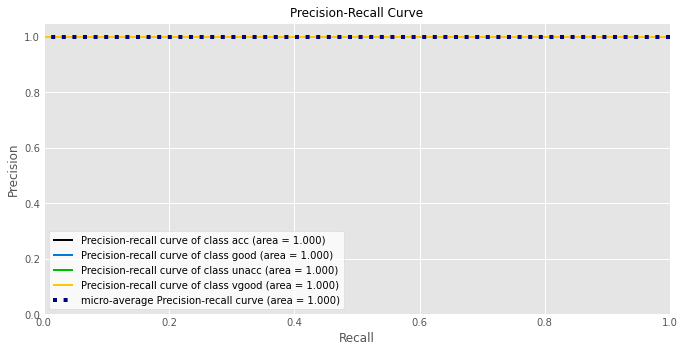

In [42]:
# plotting precision and recall curves
plt.style.use("ggplot")
skplt.metrics.plot_precision_recall(y_test, pred_probs, figsize=(10,5))
plt.legend(facecolor="white")
plt.show()

The model seems to overfit the data. This is probably from due to only training the model using ordinal features. Let's look at an ROC curve and confusion matrix to confirm these results.

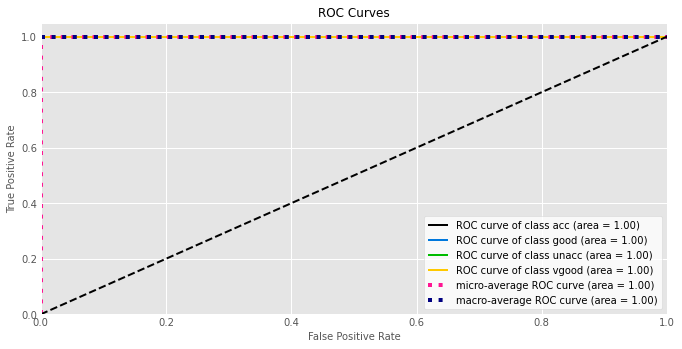

In [43]:
# plotting ROC curves
plt.style.use("ggplot")
skplt.metrics.plot_roc(y_test, pred_probs, figsize=(10,5))
plt.legend(facecolor="white")
plt.show()

As expected, the roc curves indicated the model is overfitting the data.

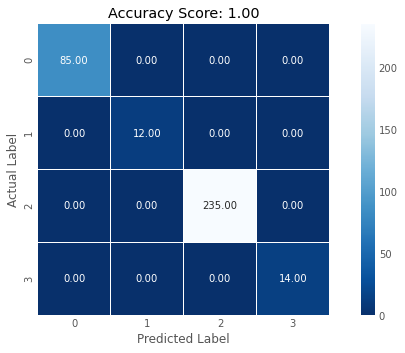

In [44]:
# creating confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_out)

# creating figure and plotting heatmap
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True,  cmap="Blues_r");
plt.ylabel("Actual Label");
plt.xlabel("Predicted Label");
plt.title("Accuracy Score: {:.2f}".format(round((np.trace(cm)) / (np.sum(cm)),2)));

In [45]:
# importing evaluation metrics and itertool
from sklearn.metrics import precision_recall_fscore_support
import itertools

# creating lists containing scores and names
score_results = list(precision_recall_fscore_support(y_test, pred_out, average="macro"))
score_names = ["precision", "recall", "fscore", "support"]

# looping through both lists and printing elements
for (score, name) in zip(score_results, score_names):
    if score != None:
        print(name, ": ", round(score, 2))
    else:
        print(name, ": ", score)

precision :  1.0
recall :  1.0
fscore :  1.0
support :  None


All scores are perfect signalling a high chance of overfitting.

The model is probably overfitting the data. My guess is the fixed amount of values in the ordinal variables make it easy for the model to memorize all future outcomes. An ideal solution might be to convert some of the ordinal variables to quantitative to reduce the chance of memorization.

## Analysis Extended

In this part, I will determine if an automobile with the below characteristics will have a 75% or better chance a potential customer will rate it at an acceptable level or above.  

- 4 doors
- Medium sized luggage boot (trunk)
- Very high maintenance costs
- 4 person passenger capacity
- Medium purchase price
- Medium safety record.  

My recommendation will be based on the first and last part of my analysis.

In [46]:
# creating dataframe with car sale opportunity
d = {"Purchase Price": ["med"], "Maintenance Costs": ["vhigh"], "Doors": ["4"],
    "Persons": ["4"], "Luggae Boot": ["med"], "Safety": ["med"]}

car_scenario = pd.DataFrame(data=d)
car_scenario

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety
0,med,vhigh,4,4,med,med


In [47]:
# predicting scenario classification based on KNN classifier
knn_car_scenario = grid.predict(car_scenario)
knn_car_scenario

array(['acc'], dtype=object)

In [48]:
# predicting scenario probability based on KNN classifier
knn_car_scenario_prob = grid.predict_proba(car_scenario)
knn_car_scenario_prob

array([[1., 0., 0., 0.]])

PyCaret is an open-source, low-code machine learning library in Python aimed to facilitate comparing and evaluating various algorithms with a few lines of code. I will use PyCaret to find a classification model with the highest F1 score for the car evaluation dataset.

In [49]:
# importing pycaret and checking library version
import pycaret
print("PyCaret Version: %s" % pycaret.__version__)

PyCaret Version: 2.3.0


In [50]:
#import classification module 
from pycaret.classification import * 

In [51]:
# setting up the data
grid = setup(data=car_data, target=car_data.columns[-1], silent = True)

,Description,Value
0,session_id,997
1,Target,Rating
2,Target Type,Multiclass
3,Label Encoded,"acc: 0, good: 1, unacc: 2, vgood: 3"
4,Original Data,"(1728, 7)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [52]:
# returning top 3 models based on F1 Score
best_models = compare_models(sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9926,0.9999,0.9749,0.9933,0.9925,0.9843,0.9844,0.1550
gbc,Gradient Boosting Classifier,0.9711,0.9986,0.9229,0.9729,0.9705,0.9393,0.9402,0.1550
et,Extra Trees Classifier,0.9653,0.9978,0.9113,0.9682,0.9653,0.9269,0.9277,0.0690
dt,Decision Tree Classifier,0.9603,0.9623,0.9028,0.9620,0.9601,0.9151,0.9157,0.0100
rf,Random Forest Classifier,0.9578,0.9971,0.8642,0.9572,0.9560,0.9109,0.9122,0.0630
lr,Logistic Regression,0.9040,0.9879,0.7115,0.9017,0.8982,0.7966,0.8001,0.6030
lda,Linear Discriminant Analysis,0.8867,0.9818,0.6261,0.8925,0.8813,0.7636,0.7695,0.0100
knn,K Neighbors Classifier,0.8892,0.9698,0.6259,0.8844,0.8785,0.7525,0.7561,0.0150
svm,SVM - Linear Kernel,0.8710,0.0000,0.6133,0.8592,0.8574,0.7162,0.7227,0.0240
ridge,Ridge Classifier,0.8536,0.0000,0.4413,0.7962,0.8229,0.6701,0.6771,0.0080


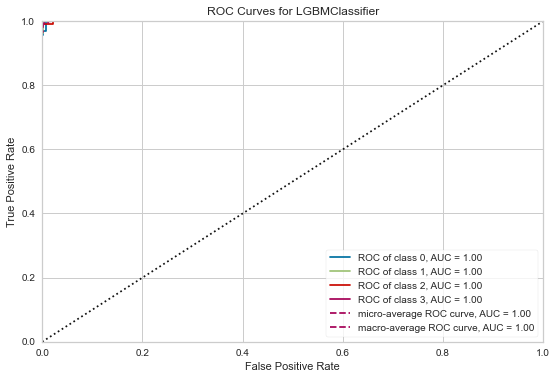

In [53]:
# AUC Plot for best model
plot_model(best_models, plot="auc")

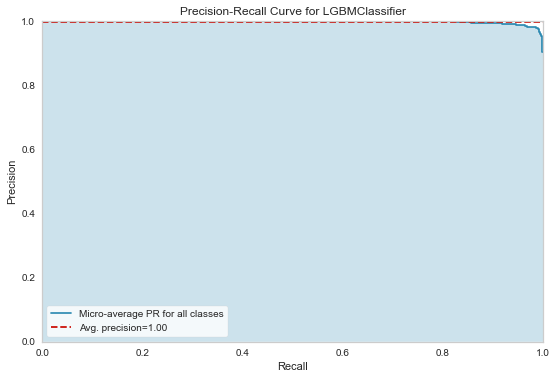

In [54]:
# precision-recall curve for best model
plot_model(best_models, plot="pr")

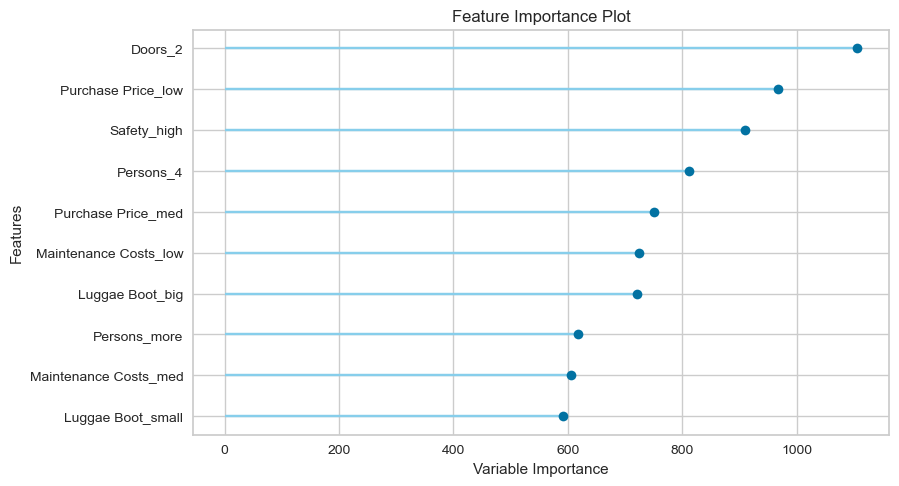

In [55]:
# feature importance for best model
plot_model(best_models, plot="feature")

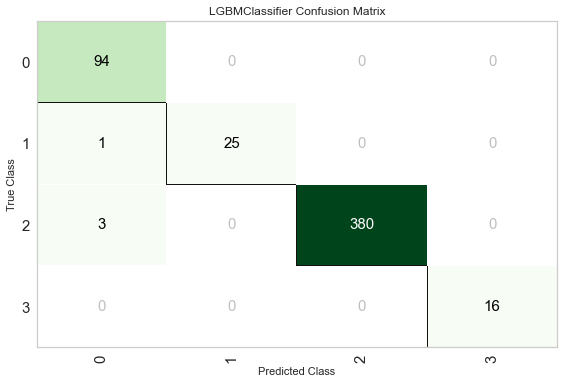

In [56]:
# confusion matrix for best model
plot_model(best_models, plot="confusion_matrix")

In [57]:
# evaluating model
evaluate_model(best_models)

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


In [58]:
# finalizing model light gradient boost model to use in prediction
final_lgbm = finalize_model(best_models)

In [59]:
# prediction based on best PyCaret model (light gradient boost model)
car_prediction = predict_model(final_lgbm, data=car_scenario)
car_prediction

,Purchase Price,Maintenance Costs,Doors,Persons,Luggae Boot,Safety,Label,Score
0,med,vhigh,4,4,med,med,acc,0.9966


## Recommendation to Client

I would not recommend the automobile listed in the scenario for a few reasons. First, the evaluation scores are deceptive. Precision, recall, f1 scores, and accuracy have scored at or near 100% for the cross-validation sets and the out-of-sample test set. I am confident this is due to not including any quantitative features in the training data. Also, most categorical features are ordinal with  3-4 categories per feature. A low number of feature categories makes it easy for most algorithms to memorize the data instead of generalizing it to a population.

Accuracy varies significantly between different classification models. Gradient boosting and tree models such as Light Gradient Boosting Machine, Gradient Boosting Classifier, Extra Trees Classifier, Decision Tree Classifier, and Random Forest Classifier have cross-validation accuracy scores above 95%. These models are usually the top choices for classification problems, but they come with a performance cost. The Naive Bayes and Quadratic Discriminant Analysis classifiers have accuracy scores below 80%. The latter is not an ideal choice for this task since it has a mean accuracy score of 24%. Although Naive Bayes has a mean accuracy score below 80%, it makes up for it with the second-lowest training time, 0.0080 seconds, and recall and precision scores above 85%. The gradient boosting and tree models mentioned earlier have AUC percentages above 96% (most near 100%). The Naive Bayes classifier model is on par at 0.97%. 

Precision scores are higher than recall scores across all models. The top five accuracy score models have precision and recall scores above 90
%. Interestingly enough, the light gradient boosting machine and Naive Bayes classifier models have a difference between precision and recall below 1.5 seconds. The performance from the Naive Bayes model shows how the effectiveness of a high-performance probability model. The AOC does not change significantly between the highest performing models. The most important feature attributes are two-door vehicles, low purchase price, high safety rating, four-person vehicles, and medium purchase price in that order. These attributes make sense as people want high safety vehicles at a low purchase price.

The tuned K-Nearest Neighbor classification model and the Light Gradient Boosting Machine model predict a rounded 100% acceptable car rating for the automobile offer. I would not recommend the automobile to the potential client even after comparing different models for a few reasons. First, the scores are probably not indicative of the general population. All of the feature attributes are categorical with a low amount of categories. Most models will have a hard time generalizing well to a population. Some of the category values are subjective and can have different ranges within them. Secondly, the sample size is relatively small. There are only 1,728 instances of automobiles. Also, there is a limited number of features. A limited number of features might not represent a larger proportion of the automobile population well. There are a few things I would change to get a positive recommendation. For starters, having more feature attributes would help some of the algorithms group cars more effectively. Next, having more numerical features might decrease the chance of a model overfitting the data. Another factor is to include more observations in the training data.